# Mathematical Underpinnings - Lab 6

In [1]:
from sklearn.metrics import mutual_info_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

## Useful functions

In [2]:
def discetize_2bins(X):
    X_discrete = 1*(X >= 0)
    return X_discrete

In [3]:
def conditional_permutation(X, Z):

    z_values = np.unique(Z)
    n_z_values = len(z_values)
    n = len(Z)

    X_b = np.zeros(n)

    for i in range(n_z_values):

        z_value_tmp = z_values[i]

        X_b[Z == z_value_tmp] = np.random.permutation(X[Z == z_value_tmp])

    return X_b

In [4]:
def conditional_mutual_information(X, Y, Z):

    z_values = np.unique(Z)
    n_z_values = len(z_values)
    n = len(Z)

    cmi = 0

    for i in range(n_z_values):

        z_value_tmp = z_values[i]
        z_condition = (Z == z_value_tmp)

        X_z = X[z_condition]
        Y_z = Y[z_condition]

        mi_XY_z = mutual_info_score(X_z, Y_z)
        p_z = np.sum(z_condition)/n

        cmi += p_z*mi_XY_z

    return cmi

In [5]:
# II(X;Y;Z)
def interaction_information(X, Y, Z):
    return conditional_mutual_information(X, Y, Z) - mutual_info_score(X, Y)

In [6]:
# II(X;Y;Z1;Z2)
def interaction_information2(X, Y, Z1, Z2):
    Z_1_and_2 = 2 * Z2 + Z1
    return interaction_information(X, Y, Z_1_and_2) - interaction_information(X, Y, Z1) - interaction_information(X, Y, Z2)

## Task 1

In [7]:
def secmi2(X, Y, Z):

    ii = 0.
    for z_var in Z.T:
        ii += interaction_information(X, Y, z_var)

    return mutual_info_score(X, Y) + ii

def secmi3(X, Y, Z):

    val = secmi2(X, Y, Z)
    for i in range(Z.shape[1]):
        for j in range(i):
            val += interaction_information2(X, Y, Z[:, i], Z[:, j])


    return val

### a)

In [8]:
def cond_indep_test_permutation(X, Y, Z, stat, B = 100):

    n_col_Z = Z.shape[1]
    Z_1dim = np.dot(Z, 2**np.linspace(0, n_col_Z-1, n_col_Z))

    if stat == "cmi":
        stat_value = conditional_mutual_information(X, Y, Z_1dim)
    if stat == "secmi2":
        stat_value = secmi2(X, Y, Z)
    if stat == "secmi3":
        stat_value = secmi3(X, Y, Z)

    condition_p_value = 0
    for b in range(B):
        X_b = conditional_permutation(X, Z_1dim)

        if stat == "cmi":
            stat_value_b = conditional_mutual_information(X_b, Y, Z_1dim)
        if stat == "secmi2":
            stat_value_b = secmi2(X_b, Y, Z)
        if stat == "secmi3":
            stat_value_b = secmi3(X_b, Y, Z)

        if stat_value <= stat_value_b:
            condition_p_value += 1

    p_value = (1 + condition_p_value)/(1 + B)

    return 2*len(X)*stat_value, p_value

### b)

In [9]:
n = 100
stats = ['cmi', 'secmi2', 'secmi3']
scenario = 'b'

y = np.random.normal(size = n)
y = np.where(y > 0, 1, -1)

z_1 = np.random.normal(y)
z_2 = np.random.normal(y)
z_3 = np.random.normal(y)

z_1_bin = np.where(z_1 > 0, 1, -1)
z_2_bin = np.where(z_2 > 0, 1, -1)
z_3_bin = np.where(z_3 > 0, 1, -1)

x = np.random.normal(z_1_bin)
x = np.where(x > 0, 1, -1)

def test_hypo(x, y, z_1, z_2, z_3, scenario, stat):

    if scenario == 'a':
        z = np.vstack([z_1, z_2]).T
    elif scenario == 'b':
        z = np.vstack([z_2, z_3]).T

    return cond_indep_test_permutation(x, y, z, stat)


In [10]:
test_hypo(x, y, z_1_bin, z_2_bin, z_3_bin, 'a', 'cmi')

(2.213557633009069, 0.5742574257425742)

In [11]:
test_hypo(x, y, z_1_bin, z_2_bin, z_3_bin, 'a', 'secmi2')

(-7.696593560112341, 0.36633663366336633)

In [12]:
test_hypo(x, y, z_1_bin, z_2_bin, z_3_bin, 'a', 'secmi3')

(2.2135576330090667, 0.5247524752475248)

In [13]:
test_hypo(x, y, z_1_bin, z_2_bin, z_3_bin, 'b', 'cmi')

(23.513502734346016, 0.009900990099009901)

In [14]:
test_hypo(x, y, z_1_bin, z_2_bin, z_3_bin, 'b', 'secmi2')

(13.690291714872311, 0.009900990099009901)

In [15]:
test_hypo(x, y, z_1_bin, z_2_bin, z_3_bin, 'b', 'secmi3')

(23.513502734346016, 0.009900990099009901)

In [19]:
from tqdm import tqdm
N = 100
results = {}
results[('a', 'cmi')] = []
results[('a', 'secmi2')] = []
results[('a', 'secmi3')] = []
results[('b', 'cmi')] = []
results[('b', 'secmi2')] = []
results[('b', 'secmi3')] = []
for _ in tqdm(range(N)):
    results[('a', 'cmi')].append(test_hypo(x, y, z_1_bin, z_2_bin, z_3_bin, 'a', 'cmi')[1])
    results[('a', 'secmi2')].append(test_hypo(x, y, z_1_bin, z_2_bin, z_3_bin, 'a', 'secmi2')[1])
    results[('a', 'secmi3')].append(test_hypo(x, y, z_1_bin, z_2_bin, z_3_bin, 'a', 'secmi3')[1])
    results[('b', 'cmi')].append(test_hypo(x, y, z_1_bin, z_2_bin, z_3_bin, 'b', 'cmi')[1])
    results[('b', 'secmi2')].append(test_hypo(x, y, z_1_bin, z_2_bin, z_3_bin, 'b', 'secmi2')[1])
    results[('b', 'secmi3')].append(test_hypo(x, y, z_1_bin, z_2_bin, z_3_bin, 'b', 'secmi3')[1])

100%|██████████| 100/100 [04:40<00:00,  2.81s/it]


In [21]:
df = pd.DataFrame.from_dict(results)

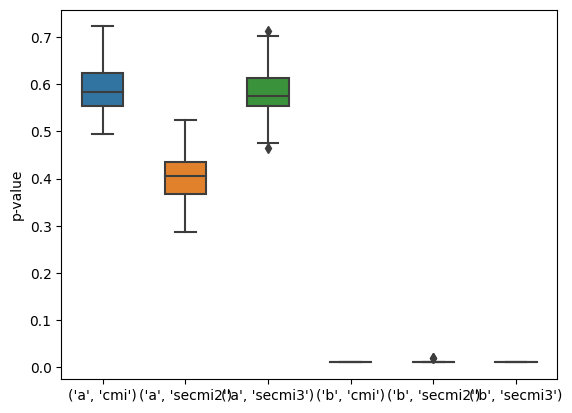

In [28]:
sns.boxplot(df, width = 0.5)
plt.ylabel('p-value')
plt.show()

### c)

In [37]:
n = 100
x = np.random.randint(0, 2, n)
z_1 = np.random.randint(0, 2, n)
z_2 = np.random.randint(0, 2, n)
z_3 = np.random.randint(0, 2, n)

cond = x + z_1 + z_2
y = np.zeros_like(x)
y[cond % 2 == 0] = np.random.choice([0, 1], size = (n,), p = [0.8, 0.2])[cond % 2 == 0]
y[cond % 2 == 1] = np.random.choice([0, 1], size = (n,), p = [0.2, 0.8])[cond % 2 == 1]

In [38]:
test_hypo(x, y, z_1, z_2, z_3, 'a', 'cmi')

(34.361685737281825, 0.009900990099009901)

In [39]:
test_hypo(x, y, z_1, z_2, z_3, 'a', 'secmi2')

(1.9459931951993497, 0.693069306930693)

In [40]:
test_hypo(x, y, z_1, z_2, z_3, 'a', 'secmi3')

(34.361685737281825, 0.009900990099009901)

In [41]:
test_hypo(x, y, z_1, z_2, z_3, 'b', 'cmi')

(0.5378391325387483, 0.9603960396039604)

In [42]:
test_hypo(x, y, z_1, z_2, z_3, 'b', 'secmi2')

(0.17664529160673167, 1.0)

In [43]:
test_hypo(x, y, z_1, z_2, z_3, 'b', 'secmi3')

(0.5378391325387483, 0.9603960396039604)

In [44]:
N = 100
results = {}
results[('a', 'cmi')] = []
results[('a', 'secmi2')] = []
results[('a', 'secmi3')] = []
results[('b', 'cmi')] = []
results[('b', 'secmi2')] = []
results[('b', 'secmi3')] = []
for _ in tqdm(range(N)):
    results[('a', 'cmi')].append(test_hypo(x, y, z_1, z_2, z_3, 'a', 'cmi')[1])
    results[('a', 'secmi2')].append(test_hypo(x, y, z_1, z_2, z_3, 'a', 'secmi2')[1])
    results[('a', 'secmi3')].append(test_hypo(x, y, z_1, z_2, z_3, 'a', 'secmi3')[1])
    results[('b', 'cmi')].append(test_hypo(x, y, z_1, z_2, z_3, 'b', 'cmi')[1])
    results[('b', 'secmi2')].append(test_hypo(x, y, z_1, z_2, z_3, 'b', 'secmi2')[1])
    results[('b', 'secmi3')].append(test_hypo(x, y, z_1, z_2, z_3, 'b', 'secmi3')[1])

100%|██████████| 100/100 [04:46<00:00,  2.86s/it]


In [45]:
df = pd.DataFrame.from_dict(results)

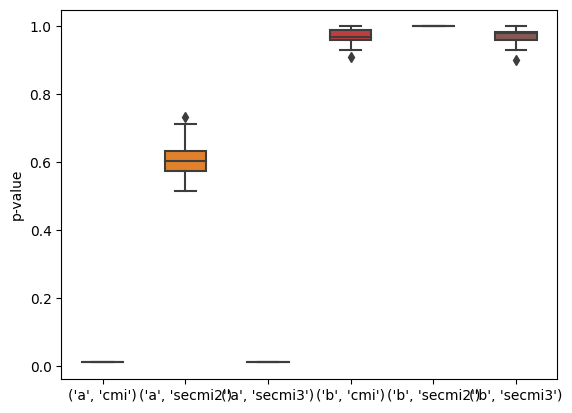

In [46]:
sns.boxplot(df, width = 0.5)
plt.ylabel('p-value')
plt.show()

## Task 2
 
in R